## Data loading

First we need to load the MNIST dataset from disk. Since in this exercise we are doing binary classification, i.e. classification between two classes, we only pick the digits 1 and 8 from the MNIST dataset here.

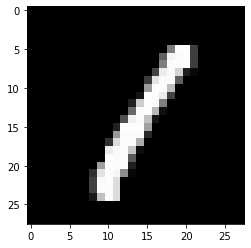

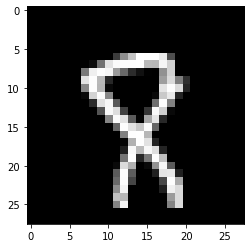

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader
from skimage.transform import resize
np.random.seed(1234)

x_train, y_train = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
x_test, y_test = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

digits = [1, 8]
train_subset_mask = np.logical_or(y_train == digits[0], y_train == digits[1])
x_train = x_train[train_subset_mask]
y_train = y_train[train_subset_mask]
y_train[y_train == digits[0]] = 0
y_train[y_train == digits[1]] = 1
test_subset_mask = np.logical_or(y_test == digits[0], y_test == digits[1])
x_test = x_test[test_subset_mask]
y_test = y_test[test_subset_mask]
y_test[y_test == digits[0]] = 0
y_test[y_test == digits[1]] = 1

plt.imshow(x_train[0], cmap='gray', interpolation = 'nearest')
plt.show()
plt.imshow(x_train[600], cmap='gray', interpolation = 'nearest')
plt.show()

## Creating downsampled versions of the dataset

In the end of this exercise we explore how the classification accuracy depends on the input image resolution. The code below creates 4 different versions of the dataset. This takes some time to execute. During your development you only need to execute this cell and the above one once and then you can modify and test your implementations below with the dataset already beeing loaded. (big advantage of jupyter notebook)

In [2]:
def resize_images(images, res_x, res_y):
    resized_images = np.zeros((images.shape[0], res_x, res_y))
    for n in range(len(images)):
        resized_images[n, :, :] = resize(images[n, :, :], resized_images.shape[1:], anti_aliasing=False)
    return resized_images

# The 28x28 images are flattend into a feature (=input) vector of size 784 here
x_train_full_res = x_train.reshape(x_train.shape[0], -1) # flatten
x_test_full_res = x_test.reshape(x_test.shape[0], -1) # flatten
print(x_train_full_res.shape, x_test_full_res.shape)

# The means of the flattend images is taken. So in this case we only have a single input feature
x_train_mean = np.mean(x_train_full_res, axis=1, keepdims=True)
x_test_mean = np.mean(x_test_full_res, axis=1, keepdims=True)
print(x_train_mean.shape, x_test_mean.shape)

# 28x28 images are downscaled into 4x4 images and then flattened to arrive at 16 features
x_train_4x4 = resize_images(x_train, 4, 4).reshape(x_train.shape[0], -1)
x_test_4x4 = resize_images(x_test, 4, 4).reshape(x_test.shape[0], -1)
print(x_train_4x4.shape, x_test_4x4.shape)

# 28x28 images are downscaled into 8x8 images and then flattened to arrive at 64 features
x_train_8x8 = resize_images(x_train, 8, 8).reshape(x_train.shape[0], -1)
x_test_8x8 = resize_images(x_test, 8, 8).reshape(x_test.shape[0], -1)
print(x_train_8x8.shape, x_test_8x8.shape)

(12593, 784) (2109, 784)
(12593, 1) (2109, 1)
(12593, 16) (2109, 16)
(12593, 64) (2109, 64)


## Logistic regression based on hand derived derivative
Implement the function `compute_derivative`. It often helps to print the `shape` of numpy arrays.

In [3]:
def compute_derivative(x, y, y_hat):
    batch_size = y.shape[0]
    distance = y_hat - y
    combined = [(y_hat[i] - y[i])*x[i] for i in range(batch_size)]
    return sum(combined)/batch_size

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def Xavier(num_features):
    return np.sqrt(3.0 / num_features)

def analytical_train_and_test(num_epochs, batch_size, learning_rate, x_train, y_train, x_test, y_test):
    # initalize our parameters w randomly
    num_features = x_train.shape[1]
    xavier_init = Xavier(num_features) # 
    w = np.random.uniform(-xavier_init, xavier_init, size=(num_features + 1,))
    w[-1] = 0 # set bias term to zero
    
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        train_err = analytical_run_epoch(batch_size, x_train, y_train, w, 'train', learning_rate=learning_rate)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = analytical_run_epoch(x_test.shape[0], x_test, y_test, w, 'test')
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log
    
def analytical_run_epoch(batch_size, x, y, w, phase, learning_rate=None):
    dataset_size = len(x)
    total_err = 0.0
    num_batches = dataset_size // batch_size
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        x_batch = x[start:end]
        y_batch = y[start:end]
        one_column_vector = np.ones((x_batch.shape[0], 1)) # a column vector with all entries beeing 1
        x_batch = np.concatenate((x_batch, one_column_vector), axis=1) # append this column vector to x
        y_hat = sigmoid(x_batch.dot(w))
        if phase == 'train':
            w_derivative = compute_derivative(x_batch, y_batch, y_hat)
            w[:] = w - learning_rate * w_derivative
        prediction = (y_hat > 0.5)
        total_err += np.sum(np.not_equal(prediction, y_batch))
    return 100 * total_err / dataset_size

def plot(train_err_log, test_err_log):
    plt.xlabel("epochs")
    plt.ylabel("error (%)")
    plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
    plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
    plt.legend(['test error', 'train error'], loc='upper right')
    plt.show()
    plt.clf()

Epoch: 1/10
	 Training Error 44.37 %
	 Test Error 43.24 %
Epoch: 2/10
	 Training Error 37.63 %
	 Test Error 22.10 %
Epoch: 3/10
	 Training Error 26.45 %
	 Test Error 15.27 %
Epoch: 4/10
	 Training Error 20.32 %
	 Test Error 12.75 %
Epoch: 5/10
	 Training Error 17.35 %
	 Test Error 11.33 %
Epoch: 6/10
	 Training Error 15.67 %
	 Test Error 11.19 %
Epoch: 7/10
	 Training Error 14.61 %
	 Test Error 11.00 %
Epoch: 8/10
	 Training Error 14.06 %
	 Test Error 10.67 %
Epoch: 9/10
	 Training Error 13.66 %
	 Test Error 10.43 %
Epoch: 10/10
	 Training Error 13.33 %
	 Test Error 10.34 %


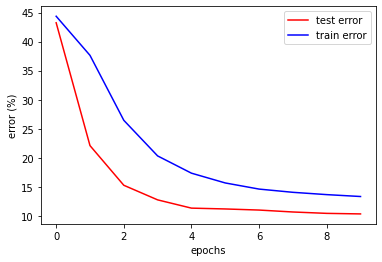

<Figure size 432x288 with 0 Axes>

In [4]:
num_epochs = 10
batch_size = 64
learning_rate = 0.5
train_err_log, test_err_log = analytical_train_and_test(num_epochs, batch_size, learning_rate,
                                             x_train_mean, y_train, x_test_mean, y_test)
plot(train_err_log, test_err_log)

## Exercises based on EDF

Implement the `forward` and `backward` method of this class. Take a look at `edf.py` for inspiration.

In [5]:
# input shape: (batch size, 1)
# output shape: (batch size, 2)
class SingleProbToProbVector(edf.CompNode):
    def __init__(self, z):
        edf.CompNodes.append(self)
        self.z = z

    def forward(self):
        self.value = np.concatenate((self.z.value, 1 - self.z.value), axis=1)

    def backward(self):
        #print(self.grad)
        grad = (self.grad[:,0] - self.grad[:,1]).reshape((-1, 1))
        self.z.addgrad(grad)

### Logistic Regression based on EDF and mean images

Use EDF to assemble a computational graph for logistic regression with the "mean" images as input. You will need the `SingleProbToProbVector` node that you implemented above. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined. `prob_node` calculates the class probabilities for each training sample, while the `loss_node` calculates the loss for the entire training batch.

In [6]:
edf.clear_compgraph()
# Define the computation graph here

# Input nodes
x_node = edf.Input()
y_node = edf.Input()

# Parameter nodes
affine_params = edf.AffineParams(x_train_mean.shape[1], 1)
#affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results


# Computation nodes
sig_node = edf.Sigmoid(edf.Affine(affine_params, x_node))
prob_node = SingleProbToProbVector(sig_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

In [7]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""

def run_epoch(batch_size, x, y, x_node, y_node, prob_node, loss_node=None):
    dataset_size = x.shape[0]
    total_err = 0.0
    num_batches = dataset_size // batch_size
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        x_node.value = x[start:end]
        y_node.value = y[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))
        if loss_node:
            edf.Backward(loss_node)
            edf.UpdateParameters()
    return 100 * total_err / dataset_size

def train_and_test(num_epochs, batch_size, x_train, y_train, x_test, y_test,
                   x_node, y_node, prob_node, loss_node):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        train_err = run_epoch(batch_size, x_train, y_train, x_node, y_node, prob_node, loss_node)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(len(x_test), x_test, y_test, x_node, y_node, prob_node)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

Epoch: 1/10
	 Training Error 40.51 %
	 Test Error 26.32 %
Epoch: 2/10
	 Training Error 29.46 %
	 Test Error 17.02 %
Epoch: 3/10
	 Training Error 21.57 %
	 Test Error 13.56 %
Epoch: 4/10
	 Training Error 17.98 %
	 Test Error 11.71 %
Epoch: 5/10
	 Training Error 16.04 %
	 Test Error 11.28 %
Epoch: 6/10
	 Training Error 14.89 %
	 Test Error 11.24 %
Epoch: 7/10
	 Training Error 14.20 %
	 Test Error 10.72 %
Epoch: 8/10
	 Training Error 13.73 %
	 Test Error 10.48 %
Epoch: 9/10
	 Training Error 13.40 %
	 Test Error 10.34 %
Epoch: 10/10
	 Training Error 13.12 %
	 Test Error 10.34 %


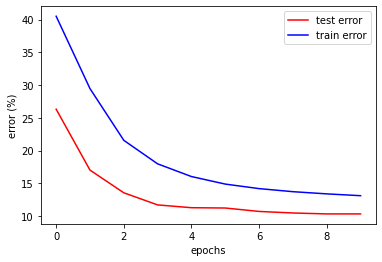

<Figure size 432x288 with 0 Axes>

In [8]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_train_mean, y_train, x_test_mean, y_test,
                                             x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

## 4x4, 8x8 and full resolution experiments based on EDF

Define computational graphs for the 4x4, 8x8 and full resolution experiments and run them. You need to call `edf.clear_compgraph()` before defining a new computation graph.

### 4x4 experiment

Epoch: 1/10
	 Training Error 11.94 %
	 Test Error 8.49 %
Epoch: 2/10
	 Training Error 10.39 %
	 Test Error 8.16 %
Epoch: 3/10
	 Training Error 9.87 %
	 Test Error 7.87 %
Epoch: 4/10
	 Training Error 9.62 %
	 Test Error 7.82 %
Epoch: 5/10
	 Training Error 9.54 %
	 Test Error 7.78 %
Epoch: 6/10
	 Training Error 9.49 %
	 Test Error 7.73 %
Epoch: 7/10
	 Training Error 9.41 %
	 Test Error 7.68 %
Epoch: 8/10
	 Training Error 9.43 %
	 Test Error 7.68 %
Epoch: 9/10
	 Training Error 9.38 %
	 Test Error 7.63 %
Epoch: 10/10
	 Training Error 9.35 %
	 Test Error 7.59 %


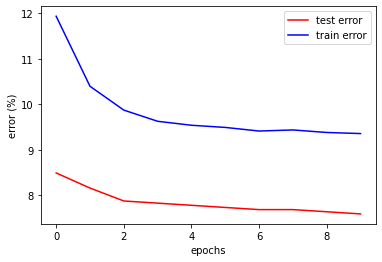

<Figure size 432x288 with 0 Axes>

In [9]:
edf.clear_compgraph()
# Define the computation graph here

# Input nodes
x_node = edf.Input()
y_node = edf.Input()

# Parameter nodes
affine_params = edf.AffineParams(x_train_4x4.shape[1], 1)
#affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results


# Computation nodes
sig_node = edf.Sigmoid(edf.Affine(affine_params, x_node))
prob_node = SingleProbToProbVector(sig_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_train_4x4, y_train, x_test_4x4, y_test,
                                             x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

### 8x8 experiment

Epoch: 1/10
	 Training Error 6.21 %
	 Test Error 4.08 %
Epoch: 2/10
	 Training Error 4.62 %
	 Test Error 3.75 %
Epoch: 3/10
	 Training Error 4.22 %
	 Test Error 3.41 %
Epoch: 4/10
	 Training Error 4.05 %
	 Test Error 3.22 %
Epoch: 5/10
	 Training Error 3.94 %
	 Test Error 2.84 %
Epoch: 6/10
	 Training Error 3.84 %
	 Test Error 2.70 %
Epoch: 7/10
	 Training Error 3.83 %
	 Test Error 2.66 %
Epoch: 8/10
	 Training Error 3.76 %
	 Test Error 2.70 %
Epoch: 9/10
	 Training Error 3.76 %
	 Test Error 2.75 %
Epoch: 10/10
	 Training Error 3.74 %
	 Test Error 2.66 %


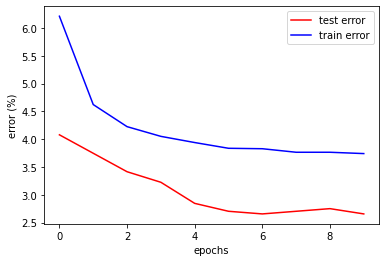

<Figure size 432x288 with 0 Axes>

In [10]:
edf.clear_compgraph()
# Define the computation graph here

# Input nodes
x_node = edf.Input()
y_node = edf.Input()

# Parameter nodes
affine_params = edf.AffineParams(x_train_8x8.shape[1], 1)
#affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results


# Computation nodes
sig_node = edf.Sigmoid(edf.Affine(affine_params, x_node))
prob_node = SingleProbToProbVector(sig_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_train_8x8, y_train, x_test_8x8, y_test,
                                             x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

### full res (=28x28) experiment

Epoch: 1/10
	 Training Error 3.51 %
	 Test Error 1.33 %
Epoch: 2/10
	 Training Error 1.94 %
	 Test Error 1.14 %
Epoch: 3/10
	 Training Error 1.74 %
	 Test Error 1.14 %
Epoch: 4/10
	 Training Error 1.69 %
	 Test Error 1.09 %
Epoch: 5/10
	 Training Error 1.62 %
	 Test Error 1.04 %
Epoch: 6/10
	 Training Error 1.52 %
	 Test Error 1.04 %
Epoch: 7/10
	 Training Error 1.51 %
	 Test Error 0.95 %
Epoch: 8/10
	 Training Error 1.51 %
	 Test Error 0.95 %
Epoch: 9/10
	 Training Error 1.45 %
	 Test Error 0.95 %
Epoch: 10/10
	 Training Error 1.42 %
	 Test Error 1.00 %


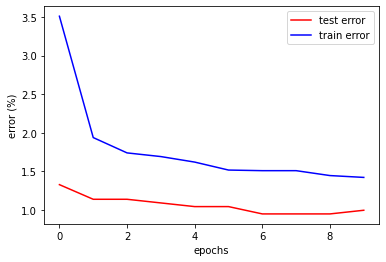

<Figure size 432x288 with 0 Axes>

In [11]:
edf.clear_compgraph()
# Define the computation graph here

# Input nodes
x_node = edf.Input()
y_node = edf.Input()

# Parameter nodes
affine_params = edf.AffineParams(x_train_full_res.shape[1], 1)
#affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results


# Computation nodes
sig_node = edf.Sigmoid(edf.Affine(affine_params, x_node))
prob_node = SingleProbToProbVector(sig_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_train_full_res, y_train, x_test_full_res, y_test,
                                             x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)